# 데이터 살펴보기

입력된 텐서에 가우시안 노이즈를 추가합니다.

함수는 입력 텐서 `x`와 노이즈 크기 `scale`을 인자로 받습니다.
그런 다음, 함수는 입력 텐서에 가우시안 노이즈를 추가하기 위해 평균이 0이고 표준 편차가 노이즈 크기인 정규 분포에서 샘플링합니다.

생성된 노이즈가 추가된 텐서는 0과 1 사이의 값으로 클립되고, PyTorch 텐서로 변환되어 반환됩니다.

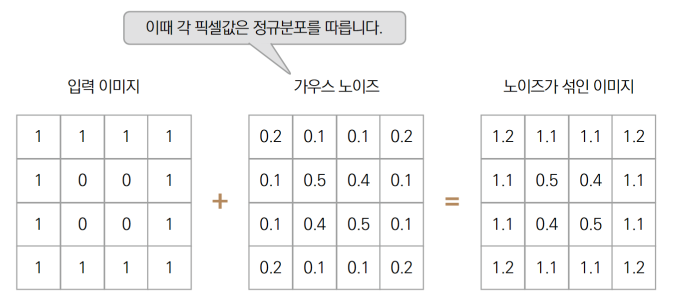

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

def gaussian_noise(x: torch.Tensor, scale=0.8):
    gaussian_data_x = x + np.random.normal(
        loc=0,
        scale=scale,
        size=x.shape
    )
    gaussian_data_x = np.clip(
        gaussian_data_x, 0, 1
    )
    gaussian_data_x = torch.Tensor(gaussian_data_x).type(torch.float32)
    return gaussian_data_x

In [24]:
a = np.array([1, 2, 3, 4])
a = a + np.random.normal(
        loc=0,
        scale=0.8,
        size=a.shape
    )
print(a, np.clip(a, 0, 1))

[1.12619906 0.99342833 2.63411012 3.68351171] [1.         0.99342833 1.         1.        ]


In [25]:
train_data = MNIST(
    root='C:/Users/patrick/datasets/torch',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = MNIST(
    root='C:/Users/patrick/datasets/torch',
    train=False,
    download=True,
    transform=ToTensor()
)

img = train_data.data[0]
gaussian = gaussian_noise(img)

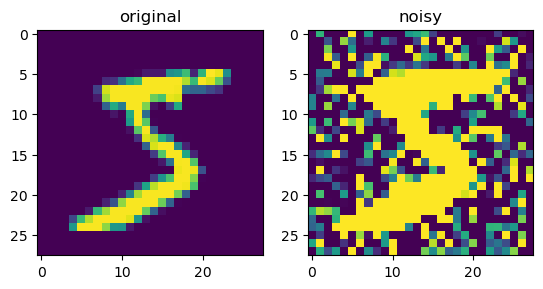

In [26]:
plt.subplot(1, 2, 1)
plt.title('original')
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.title('noisy')
plt.imshow(gaussian)
plt.show()

이 코드는 Matplotlib를 사용하여 이미지와 해당 이미지에 가우시안 노이즈가 추가된 이미지를 함께 시각화하는 파이썬 코드입니다. 코드는 먼저 `img` 변수에 저장된 원본 이미지와 `gaussian` 변수에 저장된 노이즈가 추가된 이미지를 각각 서브플롯으로 나누어 시각화합니다. `plt.subplot()` 함수를 사용하여 두 개의 서브플롯을 생성하고, `plt.title()` 함수를 사용하여 각각의 서브플롯에 제목을 추가합니다. 마지막으로 `plt.imshow()` 함수를 사용하여 이미지를 시각화하고, `plt.show()` 함수를 사용하여 시각화된 이미지를 보여줍니다.

개선점으로는, 이미지를 시각화할 때 `plt.imshow()` 함수에 `cmap` 매개변수를 추가하여 색상 맵을 지정할 수 있습니다. 또한, 이미지의 크기를 조정하는 `plt.figure(figsize=(x, y))` 함수를 사용하여 이미지의 크기를 조정할 수 있습니다.



# 학습용 데이터 만들기

In [27]:
from torch.utils.data.dataset import Dataset

class Denoising(Dataset):
    def __init__(self):
        self.mnist = MNIST(
            root='C:/Users/patrick/datasets/torch',
            train=True,
            download=True,
            transform=ToTensor()
        )
        self.data = []
        
        for i in range(len(self.mnist)):
            noisy_input = gaussian_noise(self.mnist.data[i]/255)
            input_tensor = noisy_input.clone().detach()
            self.data.append(torch.unsqueeze(input_tensor, dim=0))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, i):
        data = self.data[i]
        label = self.mnist.data[i]/255
        return data, label

# 인코더 모델 정의하기

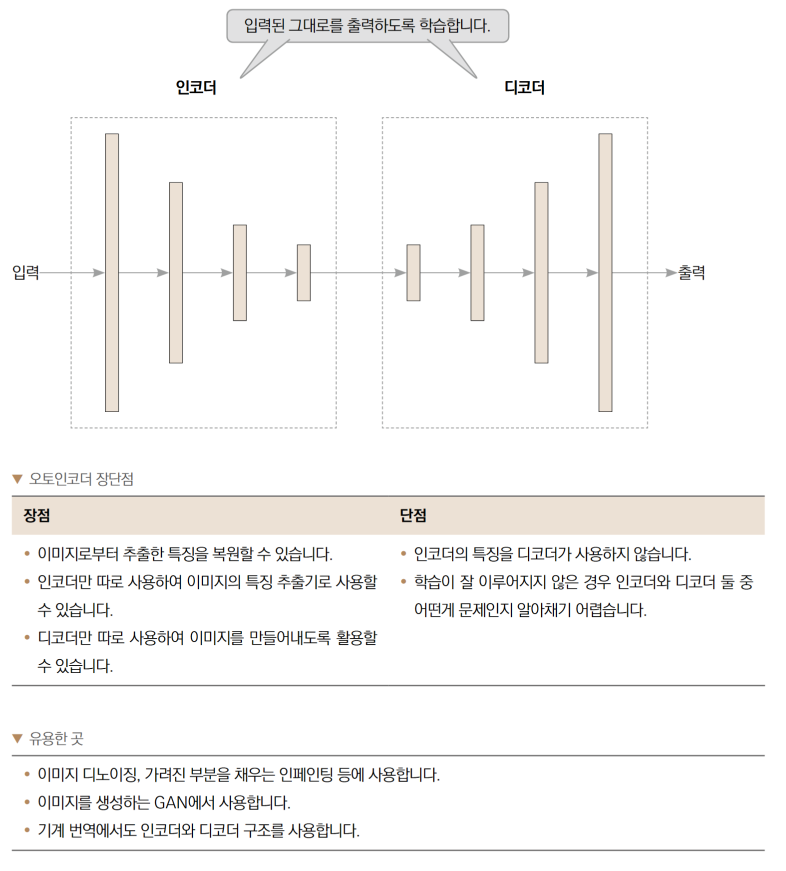

In [28]:
import torch.nn as nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels,
            hidden_dim,
            kernel_size=3,
            padding=1
        )
        self.conv2 = nn.Conv2d(
            hidden_dim,
            out_channels,
            kernel_size=3,
            padding=1
        )     
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        
        return x
    
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
        self.conv2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)        
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.conv1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim=8)
        self.conv2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16)    
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.upsample1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2)
        self.upsample2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2)        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample1(x)
        x = self.conv2(x)
        x = self.upsample2(x)
        x = self.conv3(x)
        
        return x

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        self.enc = Encoder()
        self.dec = Decoder()
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x)
        
        return x

`Encoder()` 클래스는 입력 이미지를 압축하는 인코더(encoder) 부분으로, 2개의 컨볼루션(convolution) 레이어와 ReLU 활성화 함수, 그리고 평균 풀링(average pooling) 레이어로 구성됩니다.

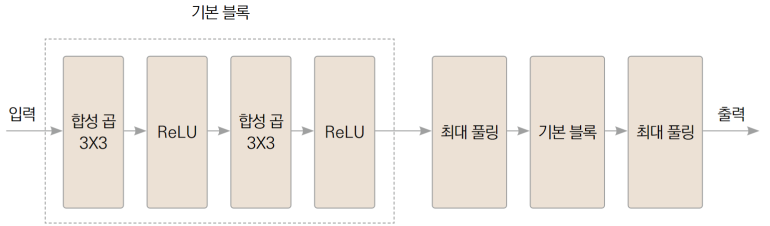

`Decoder()` 클래스는 압축된 이미지를 복원하는 디코더(decoder) 부분으로, 전치 컨볼루션(transposed convolution) 레이어와 ReLU 활성화 함수로 구성됩니다. `CAE()` 클래스는 인코더와 디코더를 결합하여 CAE 모델을 정의합니다.

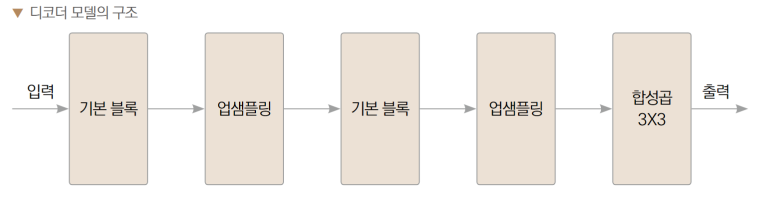

`forward()` 메서드는 각 클래스에서 입력 데이터를 받아서 출력 데이터를 반환합니다. `Encoder()` 클래스에서는 입력 이미지를 압축하여 출력합니다. `Decoder()` 클래스에서는 압축된 이미지를 복원하여 출력합니다. `CAE()` 클래스에서는 인코더와 디코더를 연결하여 입력 이미지를 압축하고 복원하여 출력합니다.

In [94]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        
        return x
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest')
        )
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        return x

class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        
        self.enc = Encoder()
        self.dec = Decoder()
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        x = torch.squeeze(x)
        
        return x

# 모델 학습하기

먼저 `Denoising()` 클래스를 사용하여 데이터셋을 불러옵니다. 그리고, `DataLoader()` 함수를 사용하여 데이터셋을 미니배치로 나누어 로드합니다. 모델은 `CAE()` 클래스를 사용하여 정의되며, `Adam()` 옵티마이저를 사용하여 모델의 파라미터를 최적화합니다. 손실 함수로는 `nn.MSELoss()`를 사용합니다.

모델을 학습시키는 부분은 `for` 반복문을 사용하여 각 에포크(epoch)마다 미니배치를 순회하며, 입력 데이터를 모델에 전달하여 예측값을 계산합니다. 그리고, 예측값과 정답 사이의 평균 제곱 오차(MSE)를 계산하여 손실을 구합니다. 손실을 역전파하여 모델의 파라미터를 업데이트하고, 현재 손실 값을 출력합니다. 마지막으로, 현재 손실 값이 이전까지의 최소 손실 값보다 작으면 모델을 저장합니다.

In [95]:
from tqdm import tqdm

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

trainset = Denoising()
train_loader = DataLoader(trainset, batch_size=32)

model = CAE().to(device)

lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)
loss_fn = nn.MSELoss()
best_loss = float('inf')

for epoch in range(20):
    iterator = tqdm(train_loader)
    
    for data, label in iterator:
        data, label = data.to(device), label.to(device)
        optim.zero_grad()
        pred = model(data)
        
        loss = loss_fn(torch.squeeze(pred), label)
        loss.backward()
        optim.step()
        iterator.set_description(f"epoch : {epoch +1}, loss : {loss:.4f}, best loss : {best_loss:.4f}")
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), './models/CAE.pth')       

cuda


epoch : 20, loss : 0.0227, best loss : 0.0171: 100%|██████████| 1875/1875 [00:10<00:00, 177.42it/s]


# 모델 성능 평가하기

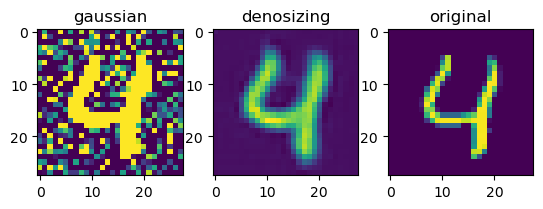

In [102]:
model.cpu() # matplotlib은 GPU 호환이 안되어, 출력을 cpu로 옮겨 줘야.

with torch.no_grad():
    model.load_state_dict(torch.load("./models/CAE.pth", map_location=device))
    
    img = test_data.data[4]
    gaussian = gaussian_noise(img)
    
    input_data = torch.unsqueeze(gaussian, dim=0)
    input_data.type(torch.float32)
    input_data.to(device)
    input_data = torch.unsqueeze(input_data, dim=0)
    
    plt.subplot(1, 3, 1)
    plt.imshow(torch.squeeze(gaussian))
    plt.title('gaussian')
    plt.subplot(1, 3, 2)
    plt.imshow(torch.squeeze(model(input_data)))
    plt.title('denosizing')    
    plt.subplot(1, 3, 3)
    plt.imshow(torch.squeeze(img))    
    plt.title('original')        
    plt.show()

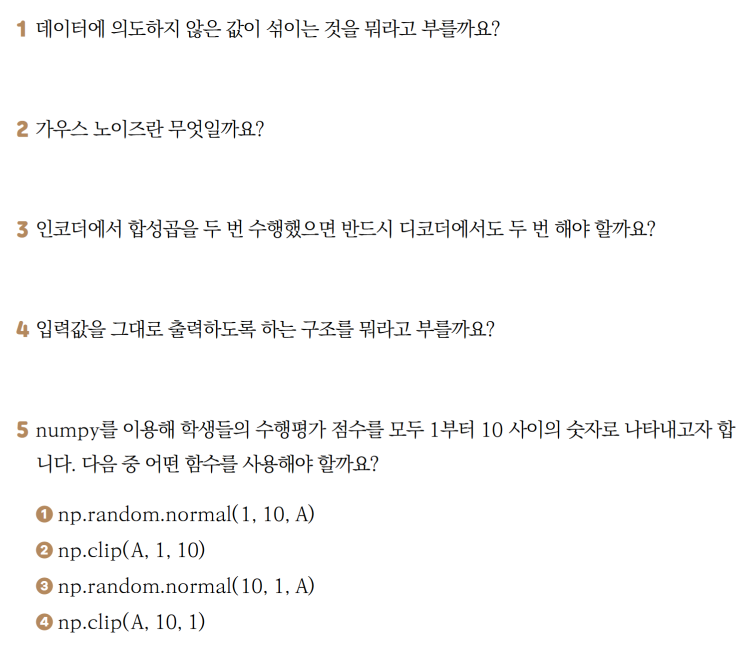

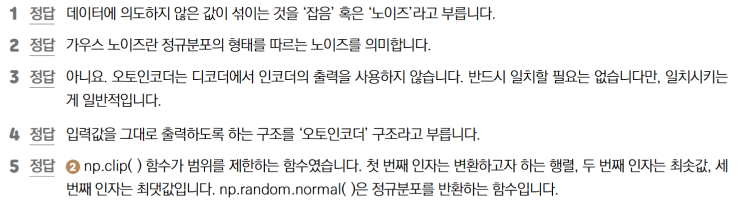